In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [42]:
data = pd.read_csv("emails.csv",encoding = "latin")
data.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


In [44]:
data.describe()

,label
count,2893.000000
mean,0.166263
std,0.372381
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [45]:
data.isna().sum()

subject    62
message     0
label       0
dtype: int64

In [46]:
data['label'].value_counts()

0    2412
1     481
Name: label, dtype: int64

Text(0.5, 1.0, 'Frequency of Both labels ')

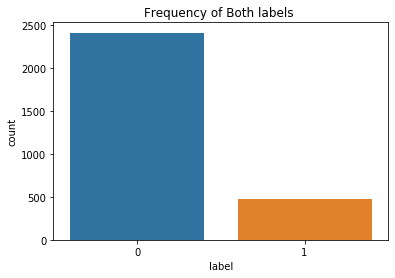

In [47]:
sns.countplot(data.label)
plt.title('Frequency of Both labels ')

[]

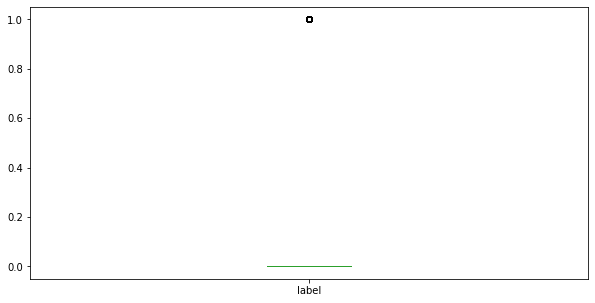

In [48]:
data.plot(kind = 'box', subplots = True, figsize=(10,5))
plt.plot()

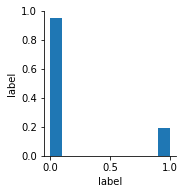

In [49]:
sns.pairplot(data)

In [50]:
from wordcloud import WordCloud

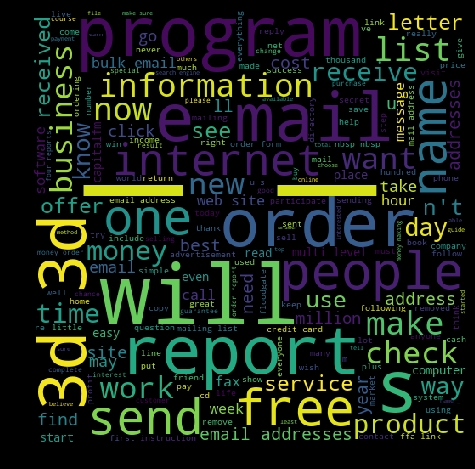

In [51]:
spam_words = ' '.join(list(data[data['label'] == 1]['message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.show()

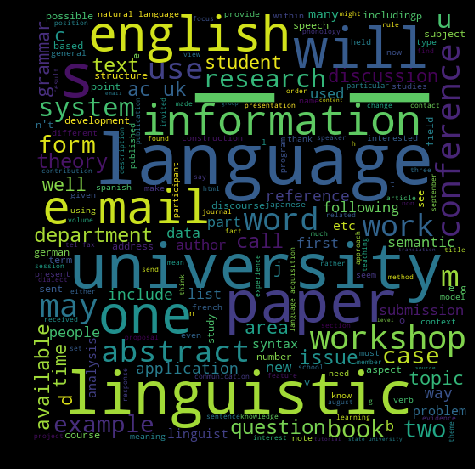

In [52]:
notspam_words = ' '.join(list(data[data['label'] == 0]['message']))
notspam_wc = WordCloud(width = 512,height = 512).generate(notspam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(notspam_wc)
plt.show()


In [53]:
X_train,X_test,y_train,y_test = train_test_split(data["message"],data["label"], test_size = 0.1, random_state = 10)

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(analyzer='word', ngram_range=(1, 3),stop_words='english')
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)
prediction = dict()

In [55]:
def hyperparameter_qual(model, model_plot, param, param_plot, params, scale):
    
    test_sizes = test_sizes = np.linspace(.1,.9,9)
    acc_param = []
    vect = CountVectorizer(analyzer='word', stop_words='english')

    max_acc = 0
    max_test_size = 0
    max_param = 0
    for j in test_sizes:
        
        X_train,X_test,y_train,y_test = train_test_split(
            data["message"],data["label"], test_size = j, random_state = 10)

        vect.fit(X_train)
        X_train_df = vect.transform(X_train)
        X_test_df = vect.transform(X_test)
        loc_y = []
        for i in params:
            model = model.set_params(**{param: i})
            model.fit(X_train_df, y_train)
            prediction = model.predict(X_test_df)
            acc = accuracy_score(y_test, prediction)
            if max_acc < acc:
                max_acc = acc
                max_test_size = j
                max_param = i
            loc_y.append(acc)
        acc_param.append(loc_y)
        
   
    plt.title(model_plot + ' Accuracy Score vs ' + param_plot)
    plt.ylabel('Accuracy Score')
    plt.xlabel(param_plot)
    plt.xscale(scale)
    for i in range(len(acc_param)):
        plt.plot(params, acc_param[i])
    tests = [int(len(data['label']) * size) for size in test_sizes]
    plt.legend(test_sizes, title='Test Set Proportion')
    plt.show()
    
    print('Max Accuracy:', max_acc)
    print('Max Test Proportion:', max_test_size)
    print('Max', param_plot + ':', max_param)

In [56]:
def create_confuse(model_name, confuse, extra_title):
    confuse = confuse.astype('float') / confuse.sum(axis=1)[:, np.newaxis]
    plt.imshow(confuse, cmap=plt.cm.Blues, interpolation='nearest')
    plt.title(model_name + ' Normalized Confusion Matrix ' + extra_title)
    plt.colorbar()
    plt.grid('off')
    plt.ylabel('Expected Label')
    plt.xlabel('Predicted Label')
    tick_marks = ['0','1']
    plt.xticks([0, 1], tick_marks)
    plt.yticks([0, 1], tick_marks)
    plt.show()

def plot_confuse(model, X_train_df, y_train, X_test_df, y_test, model_name, extra_title):
    model.fit(X_train_df, y_train)
    prediction = model.predict(X_test_df)
    
    confuse = confusion_matrix(y_test, prediction)
    create_confuse(model_name, confuse, extra_title)

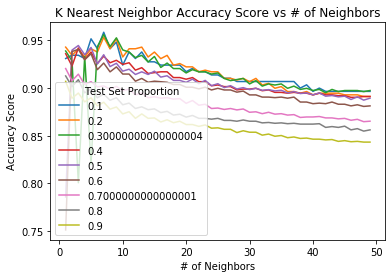

Max Accuracy: 0.9586206896551724
Max Test Proportion: 0.1
Max # of Neighbors: 7


In [57]:
from sklearn.neighbors import KNeighborsClassifier

params = range(1,50)
hyperparameter_qual(KNeighborsClassifier(), 'K Nearest Neighbor', 'n_neighbors', '# of Neighbors', params, 'linear')

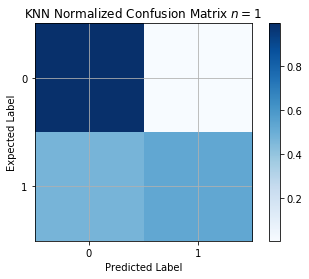

In [58]:
plot_confuse(KNeighborsClassifier(n_neighbors=1), X_train_df, y_train, X_test_df, y_test, 'KNN', '$n = 1$')

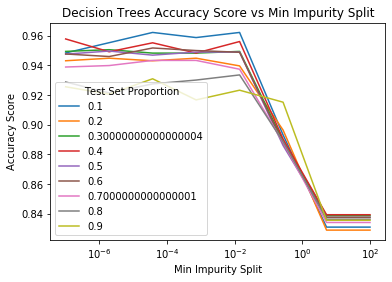

Max Accuracy: 0.9620689655172414
Max Test Proportion: 0.1
Max Min Impurity Split: 3.727593720314938e-05


In [59]:
from sklearn import tree

dtc = tree.DecisionTreeClassifier()
params = np.logspace(-7, 2, num=8)

hyperparameter_qual(dtc, 'Decision Trees', 'min_impurity_split', 'Min Impurity Split', params, 'log')

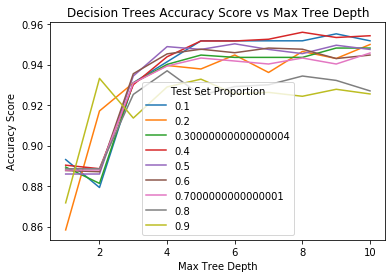

Max Accuracy: 0.9559585492227979
Max Test Proportion: 0.4
Max Max Tree Depth: 8


In [60]:
params = range(1,11)

hyperparameter_qual(tree.DecisionTreeClassifier(), 'Decision Trees', 'max_depth', 'Max Tree Depth', params, 'linear')

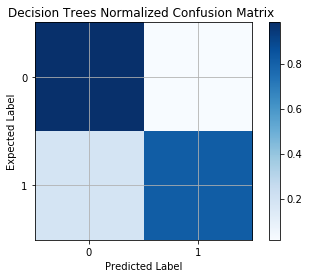

In [61]:
plot_confuse(tree.DecisionTreeClassifier(), X_train_df, y_train, X_test_df, y_test, 'Decision Trees', '')

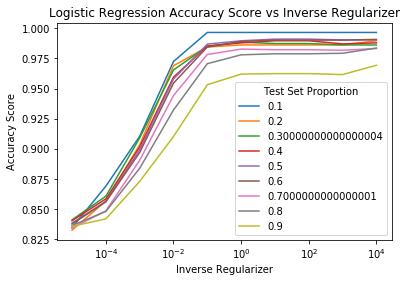

Max Accuracy: 0.996551724137931
Max Test Proportion: 0.1
Max Inverse Regularizer: 0.1


In [62]:
params = np.logspace(-5, 4, num=10)
hyperparameter_qual(LogisticRegression(), 'Logistic Regression', 'C', 'Inverse Regularizer', params, 'log')

In [63]:
model = LogisticRegression(C=1000, tol=0.01)
model.fit(X_train_df,y_train)
prediction["Logistic"] = model.predict(X_test_df)
accuracy_score(y_test,prediction["Logistic"])

0.996551724137931

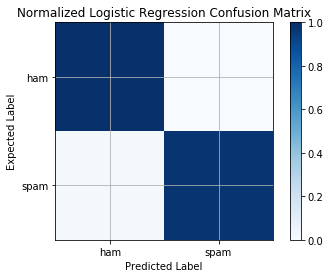

In [64]:
confmat = confusion_matrix(y_test, prediction["Logistic"])
confmat = confmat.astype('float') / confmat.sum(axis=1)[:, np.newaxis]
plt.imshow(confmat, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Normalized Logistic Regression Confusion Matrix')
plt.colorbar()
plt.grid('off')
plt.ylabel('Expected Label')
plt.xlabel('Predicted Label')
tick_marks = ['ham', 'spam']
plt.xticks([0, 1], tick_marks)
plt.yticks([0, 1], tick_marks)
plt.show()

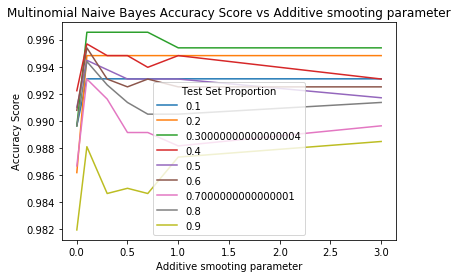

Max Accuracy: 0.9965437788018433
Max Test Proportion: 0.30000000000000004
Max Additive smooting parameter: 0.1


In [65]:
params = [0.001,0.1,0.3,0.5,0.7,1,3]

hyperparameter_qual(MultinomialNB(), 'Multinomial Naive Bayes', 'alpha', 'Additive smooting parameter', params, 'linear')

accuracy: 0.996551724137931


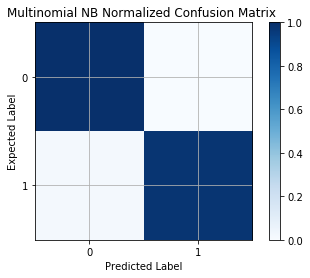

In [66]:
model = MultinomialNB(alpha=0.7)
model.fit(X_train_df,y_train)
prediction["MultinomialNB"] = model.predict(X_test_df)
print ("accuracy: "+str(accuracy_score(y_test,prediction["MultinomialNB"])))
plot_confuse(MultinomialNB(), X_train_df, y_train, X_test_df, y_test, 'Multinomial NB', '')